In [48]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory_numerical, get_temp_adiabat_surf
from isca_tools.thesis.profile_fitting import get_tropopause_lev_ind, get_mse_env, interp_var_to_pnorm, get_p_from_pnorm, \
    get_pnorm
from isca_tools.utils.xarray import convert_ds_dtypes, flatten_to_numpy, unflatten_from_numpy
from isca_tools.utils.decomposition import pca_on_xarray, scaled_k_means
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [49]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [50]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [58]:
lcl_method = 'physical'
# lcl_method = 'empirical'
# lcl_method = 'empirical2'
path_processed = f'/Users/joshduffield/Desktop/ds_mse_env_{lcl_method}_lcl.nc'
load_processed = os.path.exists(path_processed)
if load_processed:
    ds = xr.open_dataset(path_processed)
    ds = ds.load()
    ds['P'] = cesm.get_pressure(ds.PS, ds.P0, ds.hyam, ds.hybm)

In [59]:
if not load_processed:
    from jobs.theory_lapse.scripts.lcl import ds, ds_lcl, find_lcl_empirical2

## LCL

I have the choice of physical or empirical saisfying following:
1. Potential temperature deviation from surface exceeds threshold.
2. This plus additional requirement that lapse rate in the model layer is below a threshold.

In [60]:
%%time
if not load_processed:
    if lcl_method == 'physical':
        ds['p_lcl'] = ds_lcl['p_lcl']
    elif lcl_method == 'empirical':
        ds['p_lcl'] = ds_lcl['p_lcl_emp']
    elif lcl_method == 'empirical2':
        ds['p_lcl'] = find_lcl_empirical2(ds.T, ds.P, ds.Z3, ds.TREFHT, ds.PREFHT)[0]
    ds['Z_at_lcl'] = get_var_at_plev(ds.Z3, ds.P, ds.p_lcl)
    ds['T_at_lcl'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl)
    ds['mse_sat_at_lcl'] = moist_static_energy(ds['T_at_lcl'], sphum_sat(ds['T_at_lcl'], ds['p_lcl']), ds['Z_at_lcl'])
    ds['lnb_ind'] = get_tropopause_lev_ind(ds.T, ds.Z3, ds.P)
    ds.attrs['lcl_method'] = lcl_method

CPU times: user 3 µs, sys: 5 µs, total: 8 µs
Wall time: 14.1 µs


In [61]:
%%time
if not load_processed:
    p_ft = 500 * 100
    ds['T_ft'] = get_var_at_plev(ds.T, ds.P, p_ft)
    ds['Z_ft'] = get_var_at_plev(ds.Z3, ds.P, p_ft)
    ds['mse_sat_ft'] = moist_static_energy(ds['T_ft'], sphum_sat(ds['T_ft'], p_ft), ds['Z_ft'])
    ds.attrs['p_ft'] = float(p_ft)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [62]:
if not load_processed:
    pbar = tqdm(total=2)
    mse_env_pnorm_dict = {}
    # Compute MSE environmental profile (separate above and below LCL)
    mse_env_use = get_mse_env(ds.T, ds.P, ds.Z3, ds.T_at_lcl, ds.p_lcl, prof_type='below_lcl')
    # Interpolate onto p_norm grid
    mse_env_pnorm_dict['below'] = interp_var_to_pnorm(mse_env_use, ds.P, mse_env_use.isel(lev=-1),
                                                      ds.P.isel(lev=-1), ds.mse_sat_at_lcl, ds.p_lcl, ds.lnb_ind)
    pbar.update(1)

    mse_env_use = get_mse_env(ds.T, ds.P, ds.Z3, ds.T_at_lcl, ds.p_lcl, prof_type='above_lcl')
    mse_env_pnorm_dict['above'] = interp_var_to_pnorm(mse_env_use, ds.P, ds.mse_sat_at_lcl, ds.p_lcl,
                                                      ds.mse_sat_ft, ds.p_ft, ds.lnb_ind)
    pbar.update(1)
    pbar.close()
    ds['mse_env'] = xr.concat([mse_env_pnorm_dict['below'][0], mse_env_pnorm_dict['above'][0]],
                              dim=xr.DataArray(['below', 'above'], dims='layer', name='layer'))
    ds['mse_env_n_extrapolate'] = xr.concat([mse_env_pnorm_dict['below'][1], mse_env_pnorm_dict['above'][1]],
                                            dim=xr.DataArray(['below', 'above'], dims='layer', name='layer'))
    del mse_env_use

In [63]:
# Save ds for future use
if not load_processed:
    save_processed = True
    ds = ds.drop_vars('P')  # large memory and quick to compute so drop
    ds = convert_ds_dtypes(ds)
    comp_level = 4
    if (not os.path.exists(path_processed)) and save_processed:
        ds.to_netcdf(path_processed, format="NETCDF4",
                     encoding={var: {"zlib": True, "complevel": comp_level} for var in ds.data_vars})
    ds['P'] = cesm.get_pressure(ds.PS, ds.P0, ds.hyam, ds.hybm)     # recompute pressure for next steps

In [64]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
z2m = cesm.load.load_z2m(invariant_data_path, var_reindex_like=ds.TREFHT)
land_frac = xr.open_dataset(invariant_data_path).LANDFRAC
lsm = land_frac > 0
land_frac = land_frac.reindex_like(ds, method="nearest", tolerance=0.01)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)

In [65]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

### Size of layer above LCL and below FT level
Next, we want to consider the temperature profile above the LCL but below the LNB level. The minimum size of this layer is approx $p_{LCL}/p_{LNB} = 10^{0.45} = 2.82$, as shown below.

So for an LCL at sea level pressure of 1000hPa, the LNB would be about 350hPa, as shown below.

354.81338923357526


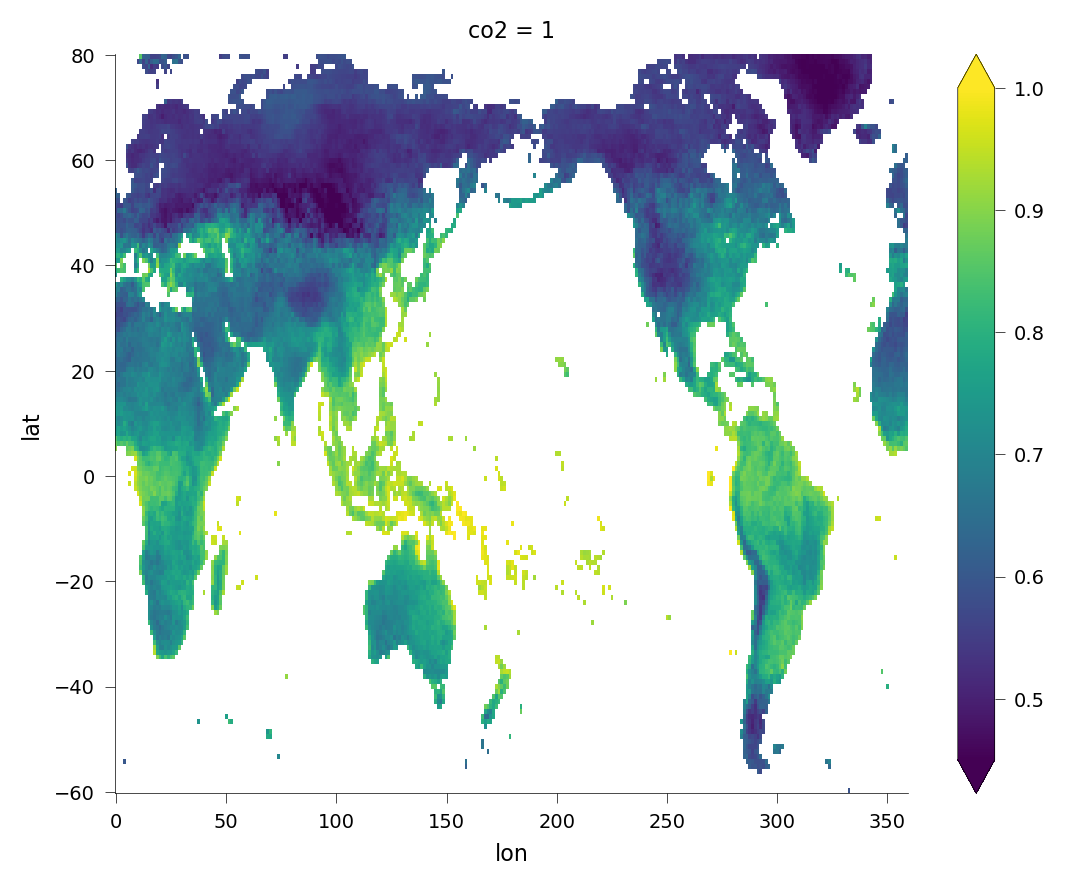

In [66]:
(np.log10(ds.p_lcl) - np.log10(ds.P.isel(lev=ds.lnb_ind))).isel(co2=0).mean(dim='sample').where(lsm).sel(
    lat=slice(-60, 80)).plot(
    vmin=0.45, vmax=1)
print(10 ** (np.log10(1000 * 100) - 0.45) / 100)

### Interpolation in region between Surface and LCL, then LCL and 500hPa
The general idea is that using DSE below LCL, and $MSE^*$ above LCL, is that these quantities should be constant in that region. Thus, if choose
to interpolate on a normalized pressure coordinate, expect profiles can be independent of LCL.

So I consider $p_{norm} = \frac{\log_{10}p - \log_{10}p_{low}}{\log_{10}p_{high} - \log_{10}p_{low}}$ in the two layers, which goes from 0 at bottom of layer to 1 above layer.

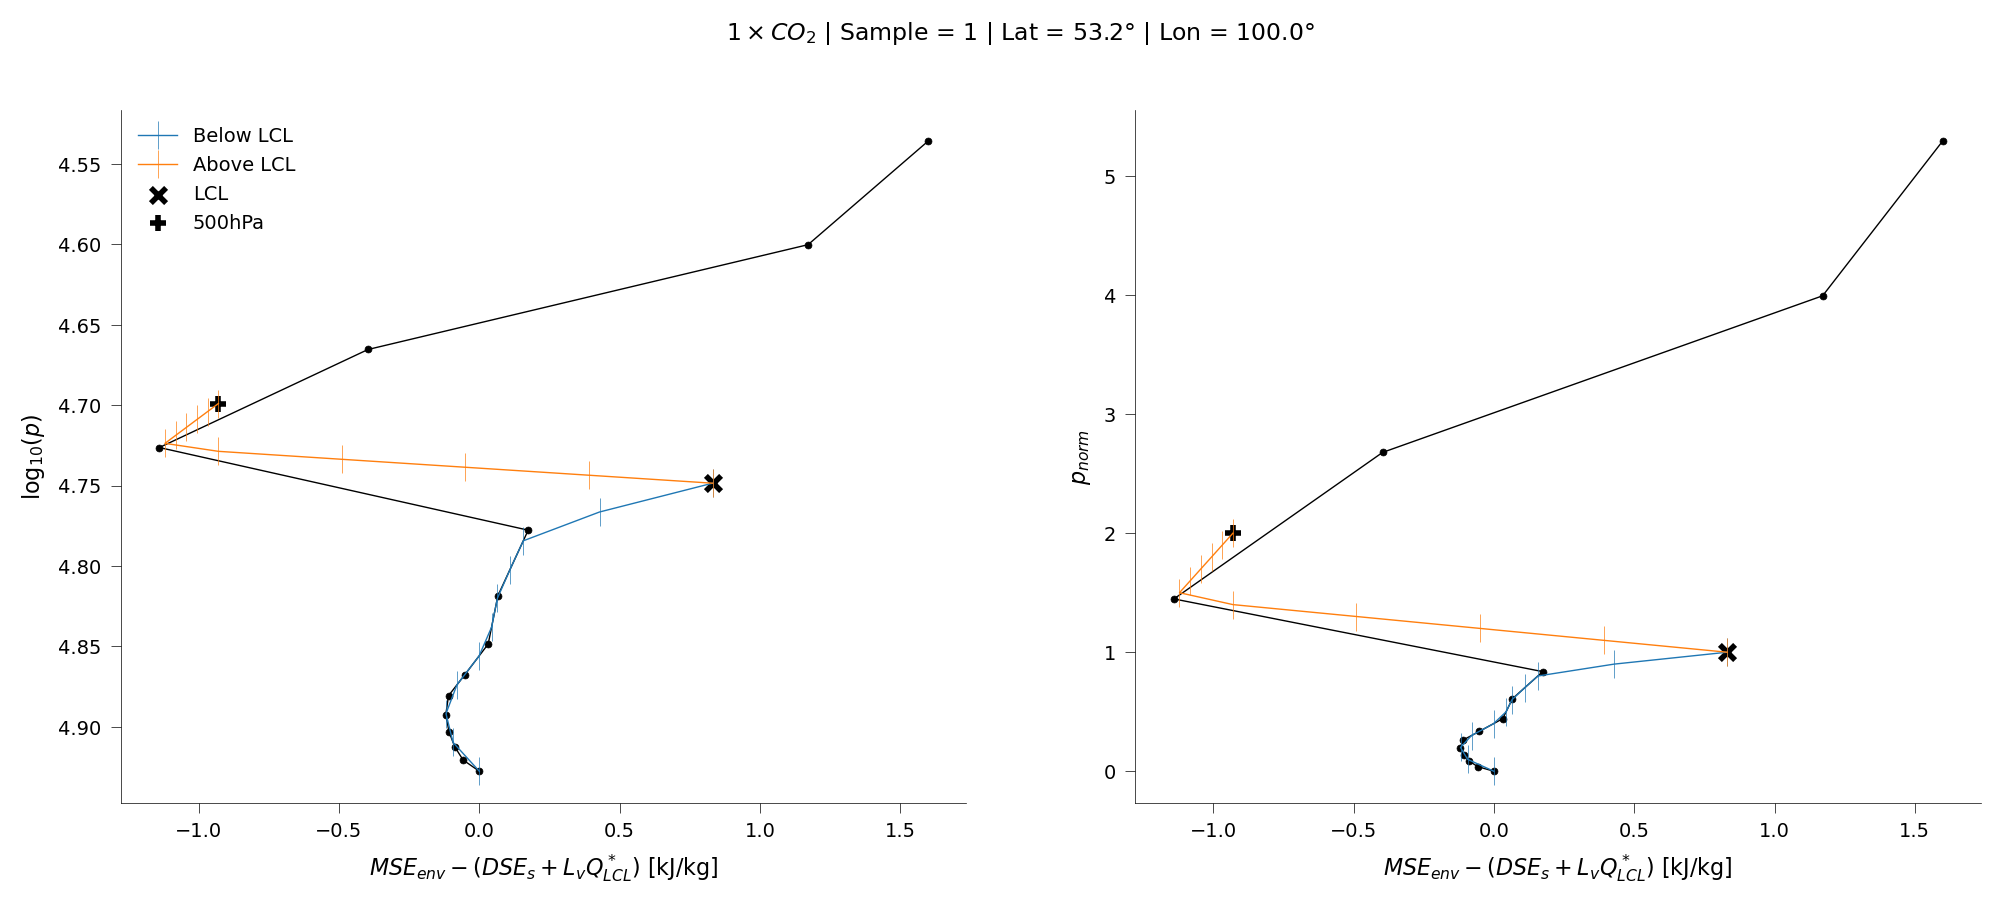

In [67]:
# logp_grid = np.append(np.arange(0, 0.06, 0.01), np.arange(0.0525, 0.45 + 0.025, 0.025))  # finer close to LCL
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=320, method='nearest')
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=300, method='nearest')  # Amazon 2
ds_use = ds.isel(co2=0).sel(lat=53, lon=100, method='nearest')  # Canada
# ds_use = ds.isel(co2=0).sel(lat=25, lon=50,method='nearest')  # Persian gulf
# ds_use = ds.isel(co2=0).sel(lat=28, lon=50, method='nearest')  # Persian gulf coastline
# ds_use = ds.isel(co2=0).sel(lat=-85, lon=100, method='nearest')       # Antarctic, hard test
# ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')  # Small inversion near LCL
# ds_use = ds.isel(co2=0).sel(lat=-35, lon=125, method='nearest')       # Very big inversion at Ocean near Australia
# ds_use = ds.isel(co2=0).sel(lat=51, lon=90, method='nearest')         # Tibet, inversion type behaviour well above LCL
# ds_use = ds.isel(co2=0).sel(lat=18, lon=0,method='nearest')      # Sahara
# ds_use = ds.isel(co2=0).sel(lat=30, lon=180, method='nearest')        # Ocean - sanity check
ds_use = ds_use.isel(sample=0)

p_max = 30 * 100
p_max = 300 * 100

fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, 12)

mse_prof_use = {key: get_mse_env(ds_use.T, ds_use.P, ds_use.Z3, ds_use.T_at_lcl, ds_use.p_lcl, key)
                for key in ['full', 'above_lcl', 'below_lcl']}
ax[0].plot(mse_prof_use['full'].where(ds_use.P >= p_max) - mse_prof_use['full'].isel(lev=-1),
           np.log10(ds_use.P).where(ds_use.P >= p_max), color='k', marker='o')
xlim_use = ax[0].get_xlim()
ax[0].plot(ds_use.mse_env.isel(layer=0),
           np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.P.isel(lev=-1), ds_use.p_lcl)),
           color='C0', label='Below LCL', marker='|', markersize=10)
ax[0].plot(ds_use.mse_env.isel(layer=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1),
           np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.p_lcl, ds_use.p_ft)),
           color='C1', label='Above LCL', marker='|', markersize=10)
ax[0].set_xlim(xlim_use)
ax[0].scatter(ds_use.mse_sat_at_lcl - mse_prof_use['full'].isel(lev=-1), np.log10(ds_use[f'p_lcl']), color='k',
              marker='x', s=30,
              lw=2, label='LCL')
ax[0].scatter(ds_use.mse_sat_ft - mse_prof_use['full'].isel(lev=-1), np.log10(ds.p_ft), color='k', marker='+', s=30,
              lw=2,
              label=f'{ds.p_ft / 100:.0f}hPa')
# ax[0].axhline(np.log10(p_ft), color='k', lw=ax_linewidth, label=f'{p_ft/100:.0f}hPa')
ax[0].invert_yaxis()

pnorm_use = get_pnorm(ds_use.P, ds_use.P.isel(lev=-1), ds_use.p_lcl)
pnorm_use = pnorm_use.where(pnorm_use < 1, get_pnorm(ds_use.P, ds_use.p_lcl, ds_use.p_ft) + 1)
ax[1].plot(mse_prof_use['full'].where(ds_use.P >= p_max) - mse_prof_use['full'].isel(lev=-1),
           pnorm_use.where(ds_use.P >= p_max), color='k', marker='o')
ax[1].plot(ds_use.mse_env.isel(layer=0), ds_use.pnorm, marker='|', markersize=10, color='C0')
ax[1].plot(ds_use.mse_env.isel(layer=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1), ds_use.pnorm + 1, marker='|',
           markersize=10, color='C1')
ax[1].scatter(ds_use.mse_env.isel(layer=0).sel(pnorm=1), 1, color='k', marker='x', s=30, lw=2)
ax[1].scatter(ds_use.mse_env.isel(layer=1).sel(pnorm=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1), 2, color='k',
              marker='+', s=30, lw=2)

ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('$MSE_{env} - (DSE_s + L_v Q^*_{LCL})$ [kJ/kg]')
ax[1].set_xlabel('$MSE_{env} - (DSE_s + L_v Q^*_{LCL})$ [kJ/kg]')
ax[1].set_ylabel('$p_{norm}$')
ax[0].legend()
fig.suptitle(
    f"${int(ds_use.co2)} \\times CO_2$ | Sample = {int(ds_use.sample)} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$",
    fontsize=8.5)
plt.show()

## Decomposition of Vertical Profile in each layer
### Initial PCA
First I find the first 2 principal components in each layer.


### Coordinates to use to find PCs
Below I plot the coordinates I use to find the PCs, and clusters later on. I avoid coastal regions, high regions and high latitude regions.
I also ignore profiles for which extrapolation is required, and that have a very large MSE deviation.

In [69]:
ds.p_ft + 100

50100.0

In [70]:
extrap_valid_thresh = 2  # no more than this many points above LNB
mse_valid_thresh = 20  # only use points where MSE deviates from conv neutral by this much
z2m_max = 2000
land_frac_thresh = 0.9
lat_valid_lims = [-60, 75]
valid = (land_frac > land_frac_thresh) & (ds.mse_env_n_extrapolate <= extrap_valid_thresh) & (
        np.abs(ds.mse_env).max(dim='pnorm') <= mse_valid_thresh) & (ds.lat > lat_valid_lims[0]) & (
                ds.lat < lat_valid_lims[1]) & (z2m < z2m_max) & (ds.p_lcl > ds.p_ft + 100*100)
valid = valid.transpose(*ds.mse_env.isel(pnorm=0).dims)         # ensure valid has same dimension order as profiles

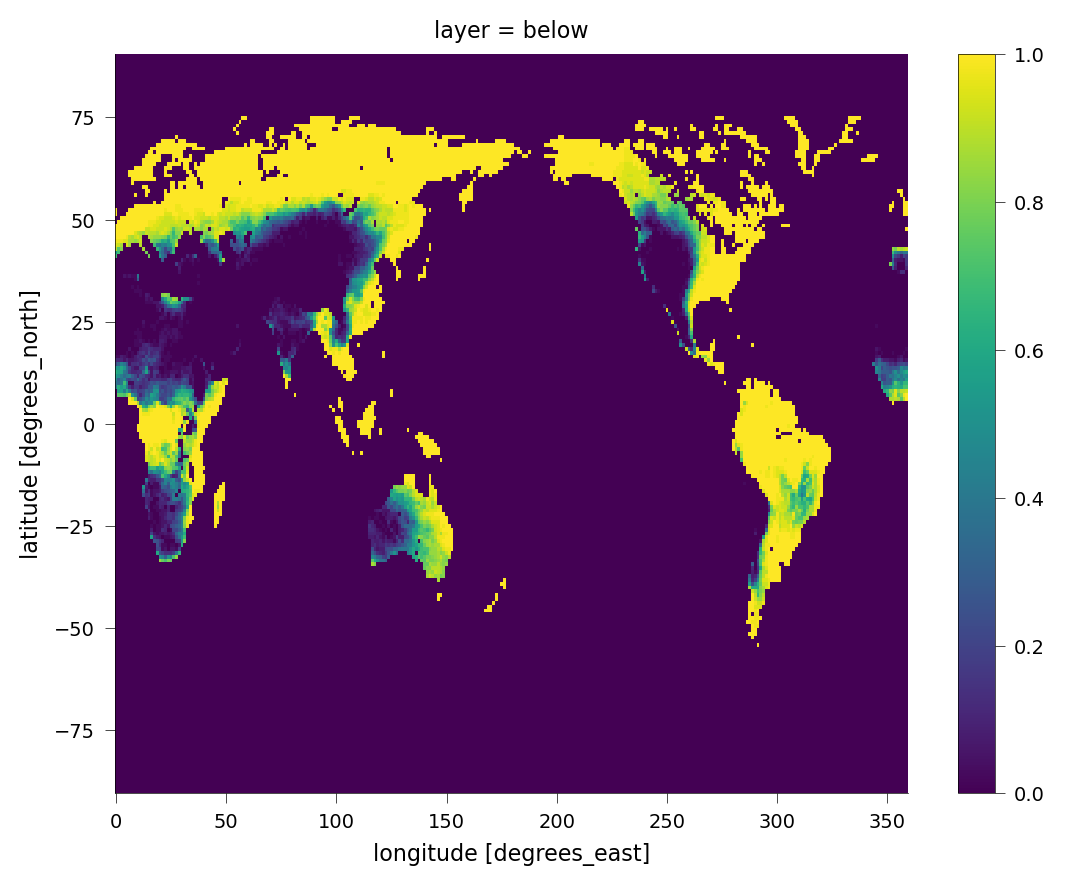

In [72]:
valid.isel(layer=0).mean(dim=['sample', 'co2']).plot()

In [73]:
def da_norm(da: xr.DataArray, dim: str, ord: float = 2) -> xr.DataArray:
    """Compute the p-norm of a DataArray along a specified dimension.

    Args:
        da (xr.DataArray): Input DataArray.
        dim (str): Dimension along which to compute the norm.
        ord (float, optional): Order of the norm (default is 2, i.e., Euclidean norm).

    Returns:
        xr.DataArray: DataArray with the norm computed along `dim`.
    """
    # np.linalg.norm does not work directly on xarray, so use apply_ufunc
    return xr.apply_ufunc(
        np.linalg.norm,
        da,
        input_core_dims=[[dim]],
        kwargs={"ord": ord},
        vectorize=True,
        dask="parallelized",  # optional, if da is dask-backed
        output_dtypes=[da.dtype],
    )

In [74]:
for key in ds.layer.values:
    print(key, np.isnan(flatten_to_numpy(ds.mse_env.sel(layer=key).where(land_frac > land_frac_thresh), 'pnorm')
                   )[flatten_to_numpy(valid.sel(layer=key))].sum())     # sanity check that valid does what is expected

below 0
above 0


In [75]:
# Compute PCs to represent profiles
n_modes = 2
pca_output = {key: list(pca_on_xarray(ds.mse_env.sel(layer=key).isel(pnorm=slice(1, 9999)),
                                      valid=valid.sel(layer=key), feature_dim_name='pnorm',
                                      standardize=True, n_modes=n_modes,
                                      reference_mean=False)) for key in ds.layer.values}
prof_norm = da_norm(ds.mse_env.isel(pnorm=slice(1, 9999)), dim='pnorm')
residual_norm_pca = {key: [] for key in pca_output}
pbar = tqdm(total=2 * n_modes)
for key in pca_output:
    for i in range(n_modes):
        var = (pca_output[key][1] * pca_output[key][0] * pca_output[key][3]).sel(mode=slice(0, i)).sum(dim='mode')
        var = ds.mse_env.sel(layer=key).isel(pnorm=slice(1, 9999)) - var
        residual_norm_pca[key].append(da_norm(var, dim='pnorm'))
        pbar.update(1)

  0%|          | 0/4 [00:00<?, ?it/s]

### Quantifying usefulness of PCs
Below, I plot the L2 norm that can be explained by each PC.

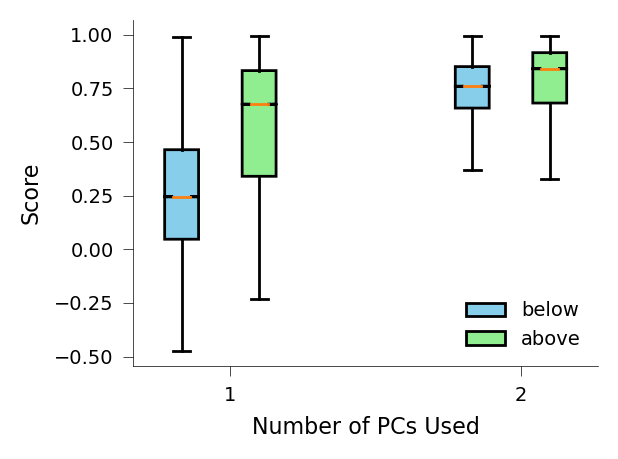

In [76]:
all_scores = []

# Collect scores for each key and mode
for key in ds.layer.values:
    score = []
    for i in range(n_modes):
        score.append((prof_norm.sel(layer=key) - residual_norm_pca[key][i]) /
                     (prof_norm.sel(layer=key) + 1e-20))
    all_scores.append([flatten_to_numpy(score[i])[flatten_to_numpy(valid.sel(layer=key))] for i in range(n_modes)])

# Prepare positions for side-by-side boxplots
positions = []
n_keys = len(ds.layer.values)
width = 0.35  # width for each boxplot
for i in range(n_modes):
    for j in range(n_keys):
        positions.append(i * (n_keys + 1) + 0.8 * j)  # spacing for groups

# Flatten the list of arrays for plotting
plot_data = [all_scores[j][i] for i in range(n_modes) for j in range(n_keys)]

# Create boxplot
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
bp = ax.boxplot(plot_data, positions=positions, widths=width, notch=True, patch_artist=True, showfliers=False)

# Optional: color by key
colors = ['skyblue', 'lightgreen']
for patch, i in zip(bp['boxes'], range(len(plot_data))):
    patch.set_facecolor(colors[i % n_keys])

# X-axis labels
tick_positions = [i * (n_keys + 1) + (n_keys - 1) / 2 for i in range(n_modes)]
ax.set_xticks(tick_positions, [f'{i + 1}' for i in range(n_modes)])

ax.set_xlabel('Number of PCs Used')
ax.set_ylabel('Score')
ax.legend([bp["boxes"][0], bp["boxes"][1]], ds.layer.values, loc='lower right')
plt.show()


### Scaled k-means
Using the PCs as an input, I compute a cluster for each profile that it is closest to. Then compute cluster profile by taking mean of all these.

In [77]:
min_cluster_size = 200
norm_find_cluster = True
k_output = {}
for key in pca_output:
    x_use = flatten_to_numpy(ds.mse_env.sel(layer=key).isel(pnorm=slice(1, 9999)), 'pnorm')
    k_output[key] = list(scaled_k_means(x_use, (pca_output[key][0] * pca_output[key][3]).to_numpy(),
                                        valid=flatten_to_numpy(valid.sel(layer=key)),
                                        min_cluster_size=min_cluster_size, norm_thresh=0, use_norm=norm_find_cluster))
    residual = x_use - k_output[key][-2] * k_output[key][0][k_output[key][2]]
    residual = unflatten_from_numpy(residual, ds.mse_env.sel(layer=key).isel(pnorm=slice(1, 9999)), 'pnorm')
    k_output[key].append(residual)  # add residual to k_output dic
del residual

1 236750
2 3672
3 0
Done after 3 iter
1 233383
2 1125
3 940
4 380
5 86
6 0
Done after 6 iter


### Compare PC and Cluster score
Below we see that on average the cluster better explains the profiles than the first PC.

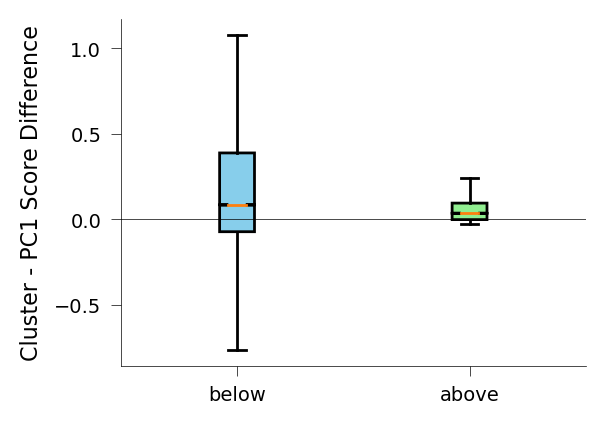

In [78]:
plot_data = []

# Collect data for each key
for key in ds.layer.values:
    plot_data.append((k_output[key][3] - flatten_to_numpy(score[0]))[flatten_to_numpy(valid.sel(layer=key))])

# Create side-by-side boxplots
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
bp = ax.boxplot(plot_data, notch=True, patch_artist=True, showfliers=False)

# Optional: color boxes
colors = ['skyblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# X-axis labels
ax.set_xticks([1, 2], ds.layer.values)
ax.set_ylabel('Cluster - PC1 Score Difference')
ax.axhline(0, color='k', lw=ax_linewidth)
plt.show()

In [79]:
def align_sign(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Multiply array `a` by either +1 or -1 to minimize least-squares error to `b`.
    Args:
        a (np.ndarray): Input array to be sign-aligned.
        b (np.ndarray): Target array.

    Returns:
        np.ndarray: `a` multiplied by +1 or -1, whichever minimizes ||s*a - b||².
    """
    sign = np.sign(np.dot(a.ravel(), b.ravel()))
    return sign * a

### Compare cluster to PCs
Here we do a sanity check that the cluster profiles differ from the PCs.

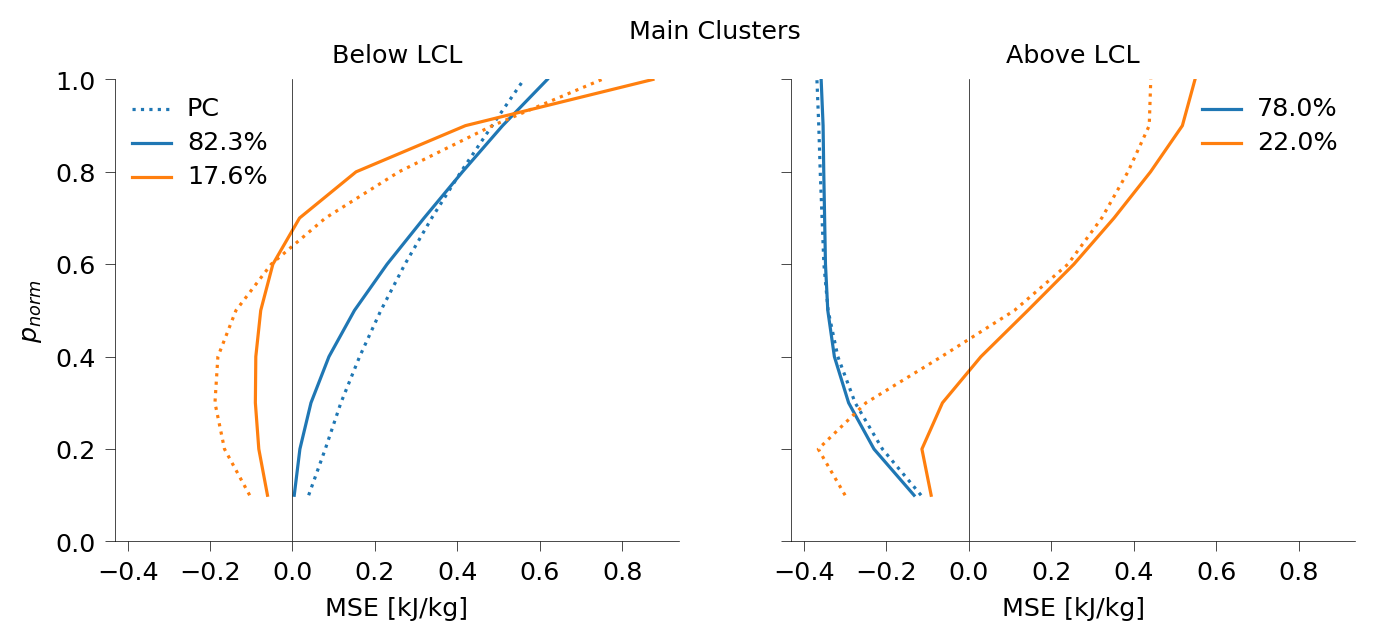

In [80]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 8)
for j, key in enumerate(pca_output):
    ax[j].set_xlabel('MSE [kJ/kg]')
    ax[j].set_title(f'{key.capitalize()} LCL')
    for i in range(n_modes):
        var = pca_output[key][0][i] * pca_output[key][3]
        ax[j].plot(var / np.linalg.norm(var), pca_output[key][0].pnorm, color=f'C{i}', linestyle=':',
                   label='PC' if i + j == 0 else None)
        if np.abs(k_output[key][0][i]).sum() > 0:
            ax[j].plot(align_sign(k_output[key][0][i], var.values), pca_output[key][0].pnorm, color=f'C{i}',
                       label=f"{(k_output[key][2] == i).sum() / k_output[key][2].size * 100:.1f}%")
update_linewidth(fig)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('MSE [kJ/kg]')
ax[0].set_xlabel('MSE [kJ/kg]')
ax[0].set_ylabel('$p_{norm}$')
ax[0].legend()
ax[1].legend()
fig.suptitle('Main Clusters')
update_fontsize(fig)
plt.show()

### Residual
Now I fit these clusters to the profiles to get a residual. I then do same process to find 2 main PCs and resultant clusters for the residual.

In [81]:
# Compute PCs to represent profiles
n_modes_residual = 2  # only have 2 residual modes
pca_output_residual = {}
k_output_residual = {}
for key in ds.layer.values:
    pca_output_residual[key] = list(pca_on_xarray(k_output[key][-1],
                                                  valid=valid.sel(layer=key), feature_dim_name='pnorm',
                                                  standardize=True, n_modes=n_modes_residual,
                                                  reference_mean=False))
    k_output_residual[key] = list(
        scaled_k_means(flatten_to_numpy(k_output[key][-1], 'pnorm'),
                       (pca_output_residual[key][0] * pca_output_residual[key][3]).to_numpy(),
                       valid=flatten_to_numpy(valid.sel(layer=key)),
                       min_cluster_size=min_cluster_size, use_norm=norm_find_cluster))

1 224913
2 9184
3 5383
4 5741
5 3935
6 1534
7 132
8 0
Done after 8 iter
1 225853
2 280
3 0
Done after 3 iter


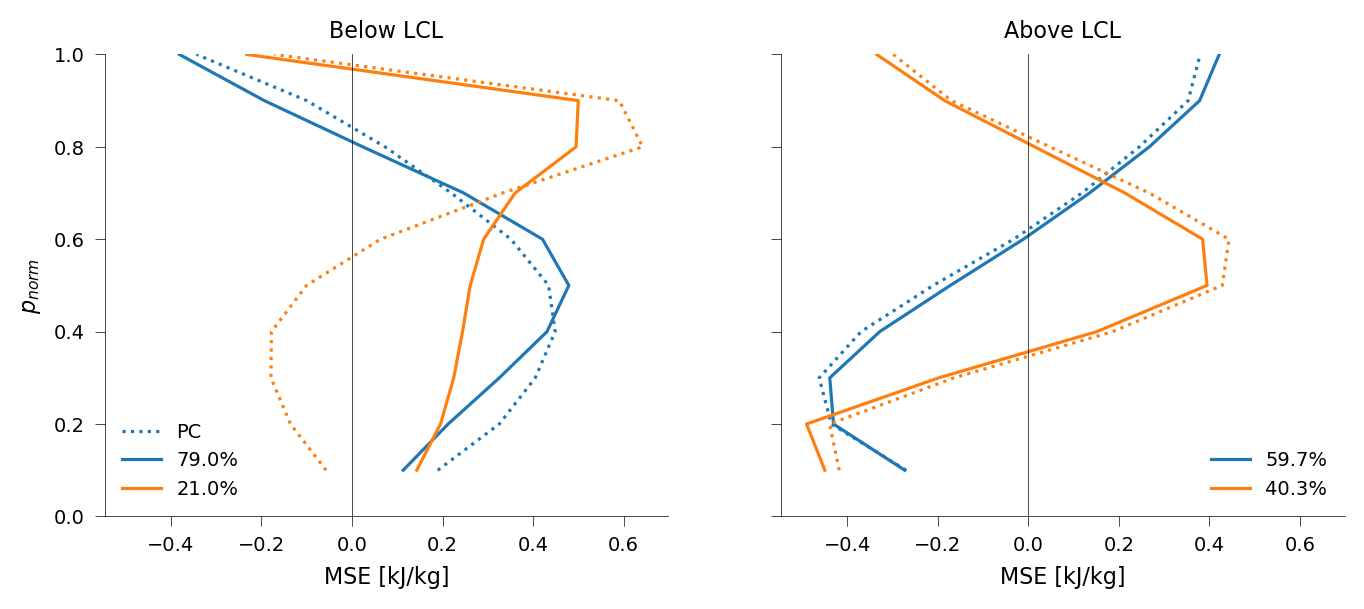

In [82]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 8)
for j, key in enumerate(pca_output):
    ax[j].set_xlabel('MSE [kJ/kg]')
    ax[j].set_title(f'{key.capitalize()} LCL')
    for i in range(n_modes_residual):
        var = pca_output_residual[key][0][i] * pca_output_residual[key][3]
        ax[j].plot(var / np.linalg.norm(var), pca_output_residual[key][0].pnorm, color=f'C{i}', linestyle=':',
                   label='PC' if i + j == 0 else None)
        if np.abs(k_output_residual[key][0][i]).sum() > 0:
            ax[j].plot(align_sign(k_output_residual[key][0][i], var.values), pca_output_residual[key][0].pnorm,
                       color=f'C{i}',
                       label=f"{(k_output_residual[key][2] == i).sum() / k_output_residual[key][2].size * 100:.1f}%")
update_linewidth(fig)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('MSE [kJ/kg]')
ax[0].set_xlabel('MSE [kJ/kg]')
ax[0].set_ylabel('$p_{norm}$')
ax[0].legend()
ax[1].legend()
plt.show()

In [83]:
dot_product_thresh = 0.85
clusters_initial = {
    key: (pca_output[key][0] * pca_output[key][3]).to_numpy()[np.linalg.norm(k_output[key][0], axis=1)[:-1] > 0] for key
    in pca_output}
atoms_final_k_means = {key: k_output[key][0][np.linalg.norm(k_output[key][0], axis=1) > 0] for key in clusters_initial}
# Only allow one of the main atoms
ignore_perm = {key: np.asarray(list(itertools.combinations(range(atoms_final_k_means[key].shape[0]), 2))) for key in
               clusters_initial}
atom_ind_no_update = {key: np.arange(atoms_final_k_means[key].shape[0]) for key in
                      clusters_initial}  # don't update the main atoms
for key in pca_output:
    for i in range(2):
        # if np.linalg.norm(k_output_residual[key][0][i]) == 0:
        #     continue
        cluster_use = (pca_output_residual[key][0] * pca_output_residual[key][3]).to_numpy()[i]
        cluster_use = cluster_use / np.linalg.norm(cluster_use)  # important for dot_product calc
        cluster_dot_product = np.abs(np.round(atoms_final_k_means[key] @ cluster_use, 2))
        print(key, f'Cluster {i}', cluster_dot_product, np.max(cluster_dot_product) < dot_product_thresh)
        if np.max(cluster_dot_product) < dot_product_thresh:
            clusters_initial[key] = np.vstack([clusters_initial[key], cluster_use])
            atoms_final_k_means[key] = np.vstack([atoms_final_k_means[key], cluster_use])
            # clusters_final[key] = np.vstack([clusters_final[key], k_output_residual[key][0][i]])
    clusters_initial[key] = clusters_initial[key] / np.linalg.norm(clusters_initial[key], axis=1)[:, None]
    atoms_final_k_means[key] = atoms_final_k_means[key] / np.linalg.norm(atoms_final_k_means[key], axis=1)[:, None]
    # Only allow one of the residual atoms
    ignore_perm[key] = np.append(ignore_perm[key],
                                 np.asarray(list(itertools.combinations(
                                     range(atom_ind_no_update[key].max() + 1, atoms_final_k_means[key].shape[0]), 2))),
                                 axis=0)

below Cluster 0 [0.05 0.49] True
below Cluster 1 [0.54 0.25 0.11] True
above Cluster 0 [0.09 0.6 ] True
above Cluster 1 [0.1  0.14 0.08] True


In [84]:
k_output_final = {}
for key in pca_output:
    x_use = flatten_to_numpy(ds.mse_env.sel(layer=key).isel(pnorm=slice(1, 9999)), 'pnorm')
    k_output_final[key] = list(scaled_k_means(x_use, atoms_final_k_means[key], norm_thresh=0,
                                              n_atom_select=2, remove_perm=ignore_perm[key],
                                              atom_ind_no_update=atom_ind_no_update[key],
                                              n_iter=10, valid=flatten_to_numpy(valid.sel(layer=key)),
                                              min_cluster_size=min_cluster_size, use_norm=norm_find_cluster))  # 0 iterations so does not recompute clusters

Removing the following atom permutations:
[[0 1]
 [2 3]]
1 143176
2 5344
3 432
4 48
5 7
6 0
Done after 6 iter
Removing the following atom permutations:
[[0 1]
 [2 3]]
1 43378
2 108
3 52
4 36
5 30
6 33
7 26
8 17
9 19
10 14


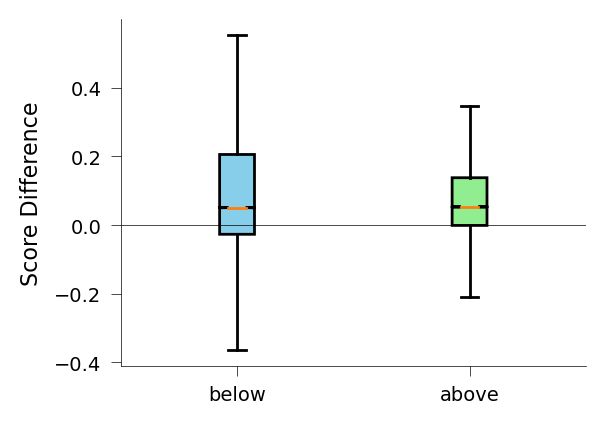

In [85]:
plot_data = []

# Collect data for each key
for key in ds.layer.values:
    plot_data.append((k_output_final[key][3] - flatten_to_numpy(score[1]))[
                         flatten_to_numpy(valid.sel(layer=key)) & flatten_to_numpy(prof_norm.sel(layer=key) > 0)])
# Create side-by-side boxplots
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
bp = ax.boxplot(plot_data, notch=True, patch_artist=True, showfliers=False)

# Optional: color boxes
colors = ['skyblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# X-axis labels
ax.set_xticks([1, 2], ds.layer.values)
ax.set_ylabel('Score Difference')
ax.axhline(0, color='k', lw=ax_linewidth)
plt.show()

In [86]:
def expand_coefs_by_cluster(coefs: np.ndarray, cluster_indices: np.ndarray) -> np.ndarray:
    """Expand coefficients into a full n_sample x n_cluster array.

    Each row i contains coefficients placed into their respective cluster columns
    according to cluster_indices[i]. Positions not belonging to any cluster for
    that sample are filled with 0.

    Args:
        coefs (np.ndarray): Array of shape (n_sample, 2) with coefficient values.
        cluster_indices (np.ndarray): Array of shape (n_sample, 2) with cluster indices
            (integers in [0, n_cluster-1]) corresponding to each coefficient.
        n_cluster (int): Total number of clusters.

    Returns:
        np.ndarray: Array of shape (n_sample, n_cluster) with coefficients placed
        in the correct cluster columns.
    """
    n_sample = coefs.shape[0]
    n_cluster = cluster_indices.max()+1
    out = np.zeros((n_sample, n_cluster))
    np.add.at(out, (np.arange(n_sample)[:, None], cluster_indices), coefs)
    return out

0 37.15488647106895
1 62.3047094075985
2 60.76722162577916
3 16.829041613921518
0 64.20388045431318
1 32.69661902642467
2 61.172378550351944
3 24.383479221271614


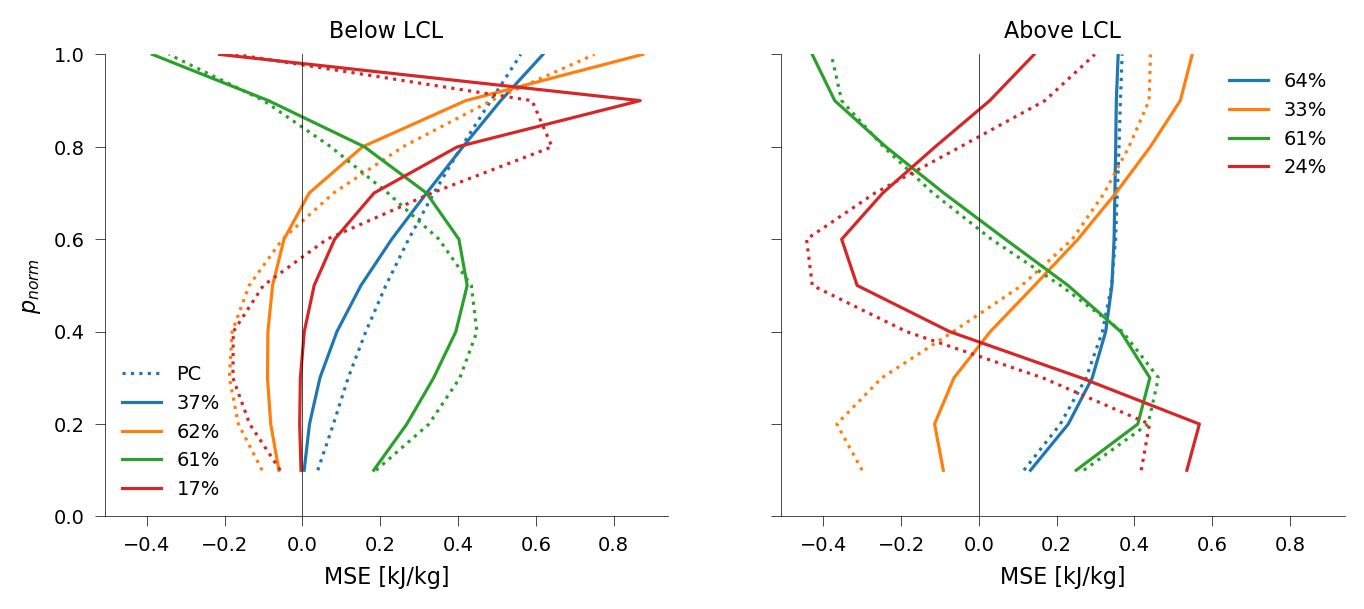

In [87]:
n_cluster = clusters_initial[key].shape[0]
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 8)
for j, key in enumerate(pca_output):
    ax[j].set_xlabel('MSE [kJ/kg]')
    ax[j].set_title(f'{key.capitalize()} LCL')
    coef_use = expand_coefs_by_cluster(k_output_final[key][4], k_output_final[key][-1][k_output_final[key][2]])
    coef_use = coef_use[flatten_to_numpy(valid.sel(layer=key))]
    for i in range(n_cluster):
        if np.abs(k_output_final[key][0][i]).max() == 0:
            continue
        print(i, (np.abs(coef_use[:, i])>0).sum() / coef_use.shape[0] * 100)
        # ax[j].plot(clusters_initial[key][i], pca_output_residual[key][0].pnorm, color=f'C{i}', linestyle=':',
        #            label='PC' if i+j == 0 else None)
        n_samples_with_mode = np.isin(k_output_final[key][2],
                                      np.where(np.isin(k_output_final[key][-1], i).any(axis=1))[0])
        n_samples_with_mode = n_samples_with_mode[flatten_to_numpy(valid.sel(layer=key))]
        n_samples_with_mode = n_samples_with_mode.sum() / n_samples_with_mode.size
        ax[j].plot(align_sign(clusters_initial[key][i], k_output_final[key][0][i]), pca_output_residual[key][0].pnorm,
                   color=f'C{i}', linestyle=':', label='PC' if i==0 and j==0 else None)
        ax[j].plot(k_output_final[key][0][i], pca_output_residual[key][0].pnorm,
                   color=f'C{i}', label=f'{n_samples_with_mode * 100:.0f}%')
update_linewidth(fig)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('MSE [kJ/kg]')
ax[0].set_xlabel('MSE [kJ/kg]')
ax[0].set_ylabel('$p_{norm}$')
ax[0].legend()
ax[1].legend()
plt.show()

In [88]:
def add_value_along_dim(da: xr.DataArray, dim: str = "pnorm", var_value: float = 0, dim_value: float = 0) -> xr.DataArray:
    """Add a coordinate value dim_value along the dim dimension with the value var_value.

    Args:
        da (xr.DataArray): Input DataArray with a 'pnorm' (or specified) dimension.
        dim (str): Name of the dimension to modify (default 'pnorm').
        value (float): Value to add.

    Returns:
        xr.DataArray: New DataArray with var_value at dim=dim_value
    """
    # Get all dimensions except the one we're expanding
    other_dims = [d for d in da.dims if d != dim]

    # Build coordinate dict for zero entry
    coords = {d: da.coords[d] for d in other_dims}
    coords[dim] = [dim_value]

    # Determine shape for the zero entry (1 for the dim being added)
    shape = tuple(1 if d == dim else da.sizes[d] for d in da.dims)

    # Create the zero DataArray
    extra_da = xr.DataArray(
        np.full(shape, var_value, dtype=da.dtype),
        dims=da.dims,
        coords=coords,
        name=da.name,
        attrs=da.attrs,
    )

    # Concatenate and sort
    return xr.concat([extra_da, da], dim=dim).sortby(dim)


## Reconstruct Profile
Below I add the cluster coefficients to the dataset, and then reconstruct the profiles in an example.

In [89]:
clusters_final = []
for key in ds.layer.values:
    clusters_final.append([unflatten_from_numpy(k_output_final[key][0][i], pca_output[key][0][0]) for i in range(n_cluster)])
    clusters_final[-1] = xr.concat(clusters_final[-1], dim=xr.DataArray(np.arange(n_cluster), dims="mode", name="mode"))
    clusters_final[-1] = add_value_along_dim(clusters_final[-1])
ds['cluster'] = xr.concat(clusters_final, dim=ds.layer)

In [90]:
coefs = []
for key in ds.layer.values:
    coefs.append(expand_coefs_by_cluster(k_output_final[key][-2], k_output_final[key][-1][k_output_final[key][2]])[:, :-1])
    # print coefs to see if match previous
    print((np.abs(coefs[-1][flatten_to_numpy(valid.sel(layer=key))])>0).sum(axis=0)/coefs[-1][flatten_to_numpy(valid.sel(layer=key))].shape[0]*100)
    coefs[-1] = xr.concat([unflatten_from_numpy(coefs[-1][:, i], ds.TREFHT) for i in range(n_cluster)],
                                    dim=ds.mode)
ds['cluster_coef'] = xr.concat(coefs, dim=ds.layer)

[37.15488647 62.30470941 60.76722163 16.82904161]
[64.20388045 32.69661903 61.17237855 24.38347922]


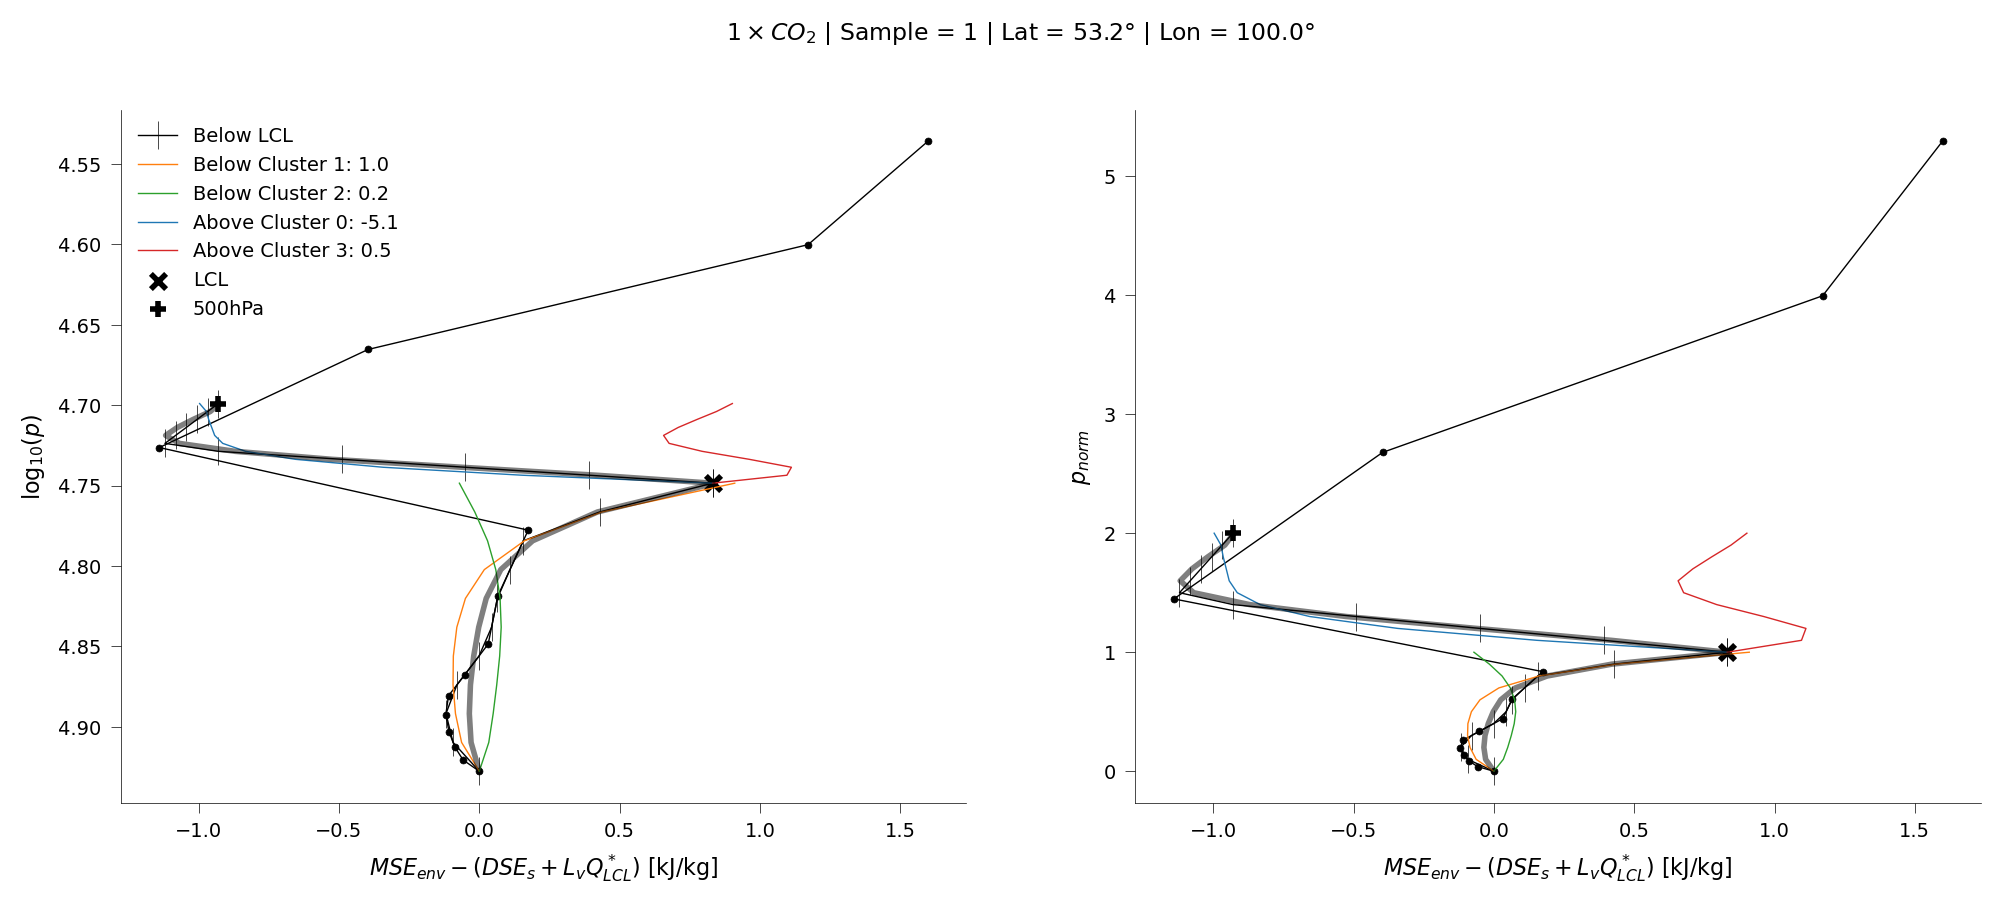

In [91]:
# logp_grid = np.append(np.arange(0, 0.06, 0.01), np.arange(0.0525, 0.45 + 0.025, 0.025))  # finer close to LCL
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=320, method='nearest')
# ds_use = ds.isel(co2=0).sel(lat=-15, lon=300, method='nearest')  # Amazon 2
ds_use = ds.isel(co2=0).sel(lat=53, lon=100, method='nearest')  # Canada
# ds_use = ds.isel(co2=0).sel(lat=25, lon=50,method='nearest')  # Persian gulf
# ds_use = ds.isel(co2=0).sel(lat=28, lon=50, method='nearest')  # Persian gulf coastline
# ds_use = ds.isel(co2=0).sel(lat=-85, lon=100, method='nearest')       # Antarctic, hard test
# ds_use = ds.isel(co2=0).sel(lat=55, lon=290, method='nearest')  # Small inversion near LCL
# ds_use = ds.isel(co2=0).sel(lat=-35, lon=125, method='nearest')       # Very big inversion at Ocean near Australia
# ds_use = ds.isel(co2=0).sel(lat=51, lon=90, method='nearest')         # Tibet, inversion type behaviour well above LCL
# ds_use = ds.isel(co2=0).sel(lat=18, lon=0,method='nearest')      # Sahara
# ds_use = ds.isel(co2=0).sel(lat=30, lon=180, method='nearest')        # Ocean - sanity check
ds_use = ds_use.isel(sample=0)

p_max = 30 * 100
p_max = 300 * 100

fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, 12)

mse_prof_use = {key: get_mse_env(ds_use.T, ds_use.P, ds_use.Z3, ds_use.T_at_lcl, ds_use.p_lcl, key)
                for key in ['full', 'above_lcl', 'below_lcl']}
ax[0].plot(mse_prof_use['full'].where(ds_use.P >= p_max) - mse_prof_use['full'].isel(lev=-1),
           np.log10(ds_use.P).where(ds_use.P >= p_max), color='k', marker='o')
xlim_use = ax[0].get_xlim()
ax[0].plot(ds_use.mse_env.isel(layer=0),
           np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.P.isel(lev=-1), ds_use.p_lcl)),
           color='k', label='Below LCL', marker='|', markersize=10)
mse_env_reconstruct = ds_use.cluster * ds_use.cluster_coef
for i in range(ds_use.mode.size):
    if float(ds_use.cluster_coef.isel(mode=i, layer=0))==0:
        continue
    ax[0].plot(mse_env_reconstruct.isel(layer=0, mode=i),
               np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.P.isel(lev=-1), ds_use.p_lcl)),
               color=f'C{i}', label=f"{ds.layer.values[0].capitalize()} Cluster {i}: {float(ds_use.cluster_coef.isel(mode=i, layer=0)):.1f}")
ax[0].plot(mse_env_reconstruct.isel(layer=0).sum(dim='mode'),
           np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.P.isel(lev=-1), ds_use.p_lcl)),
           color='k', alpha=0.5, lw=2)

ax[0].plot(ds_use.mse_env.isel(layer=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1),
           np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.p_lcl, ds_use.p_ft)),
           color='k', marker='|', markersize=10)
for i in range(ds_use.mode.size):
    if float(ds_use.cluster_coef.isel(mode=i, layer=1))==0:
        continue
    ax[0].plot(mse_env_reconstruct.isel(layer=1, mode=i) + ds_use.mse_env.isel(layer=0).sel(pnorm=1),
               np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.p_lcl, ds_use.p_ft)),
               color=f'C{i}', label=f"{ds.layer.values[1].capitalize()} Cluster {i}: {float(ds_use.cluster_coef.isel(mode=i, layer=1)):.1f}")
ax[0].plot(mse_env_reconstruct.isel(layer=1).sum(dim='mode') + ds_use.mse_env.isel(layer=0).sel(pnorm=1),
           np.log10(get_p_from_pnorm(ds_use.pnorm, ds_use.p_lcl, ds_use.p_ft)),
           color='k', alpha=0.5, lw=2)

# ax[0].set_xlim(xlim_use)
ax[0].scatter(ds_use.mse_sat_at_lcl - mse_prof_use['full'].isel(lev=-1), np.log10(ds_use[f'p_lcl']), color='k',
              marker='x', s=30,
              lw=2, label='LCL')
ax[0].scatter(ds_use.mse_sat_ft - mse_prof_use['full'].isel(lev=-1), np.log10(ds.p_ft), color='k', marker='+', s=30,
              lw=2,
              label=f'{ds.p_ft / 100:.0f}hPa')
# ax[0].axhline(np.log10(p_ft), color='k', lw=ax_linewidth, label=f'{p_ft/100:.0f}hPa')
ax[0].invert_yaxis()

pnorm_use = get_pnorm(ds_use.P, ds_use.P.isel(lev=-1), ds_use.p_lcl)
pnorm_use = pnorm_use.where(pnorm_use < 1, get_pnorm(ds_use.P, ds_use.p_lcl, ds_use.p_ft) + 1)
ax[1].plot(mse_prof_use['full'].where(ds_use.P >= p_max) - mse_prof_use['full'].isel(lev=-1),
           pnorm_use.where(ds_use.P >= p_max), color='k', marker='o')
ax[1].plot(ds_use.mse_env.isel(layer=0), ds_use.pnorm, marker='|', markersize=10, color='k')
ax[1].plot(ds_use.mse_env.isel(layer=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1), ds_use.pnorm + 1, marker='|',
           markersize=10, color='k')
ax[1].scatter(ds_use.mse_env.isel(layer=0).sel(pnorm=1), 1, color='k', marker='x', s=30, lw=2)
ax[1].scatter(ds_use.mse_env.isel(layer=1).sel(pnorm=1) + ds_use.mse_env.isel(layer=0).sel(pnorm=1), 2, color='k',
              marker='+', s=30, lw=2)

for i in range(ds_use.mode.size):
    if float(ds_use.cluster_coef.isel(mode=i, layer=0))==0:
        continue
    ax[1].plot(mse_env_reconstruct.isel(layer=0, mode=i),
               ds_use.pnorm, color=f'C{i}')
ax[1].plot(mse_env_reconstruct.isel(layer=0).sum(dim='mode'),
               ds_use.pnorm, color='k', alpha=0.5, lw=2)

for i in range(ds_use.mode.size):
    if float(ds_use.cluster_coef.isel(mode=i, layer=1))==0:
        continue
    ax[1].plot(mse_env_reconstruct.isel(layer=1, mode=i) + ds_use.mse_env.isel(layer=0).sel(pnorm=1),
               ds_use.pnorm + 1, color=f'C{i}')
ax[1].plot(mse_env_reconstruct.isel(layer=1).sum(dim='mode') + ds_use.mse_env.isel(layer=0).sel(pnorm=1),
               ds_use.pnorm + 1, color='k', alpha=0.5, lw=2)


ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('$MSE_{env} - (DSE_s + L_v Q^*_{LCL})$ [kJ/kg]')
ax[1].set_xlabel('$MSE_{env} - (DSE_s + L_v Q^*_{LCL})$ [kJ/kg]')
ax[1].set_ylabel('$p_{norm}$')
ax[0].legend()
ax[0].legend()
fig.suptitle(
    f"${int(ds_use.co2)} \\times CO_2$ | Sample = {int(ds_use.sample)} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$",
    fontsize=8.5)
plt.show()

## Cluster coefficients
Below I plot how the Fraction of days active for given mode; and the coefficient value vary spatially and with warming.

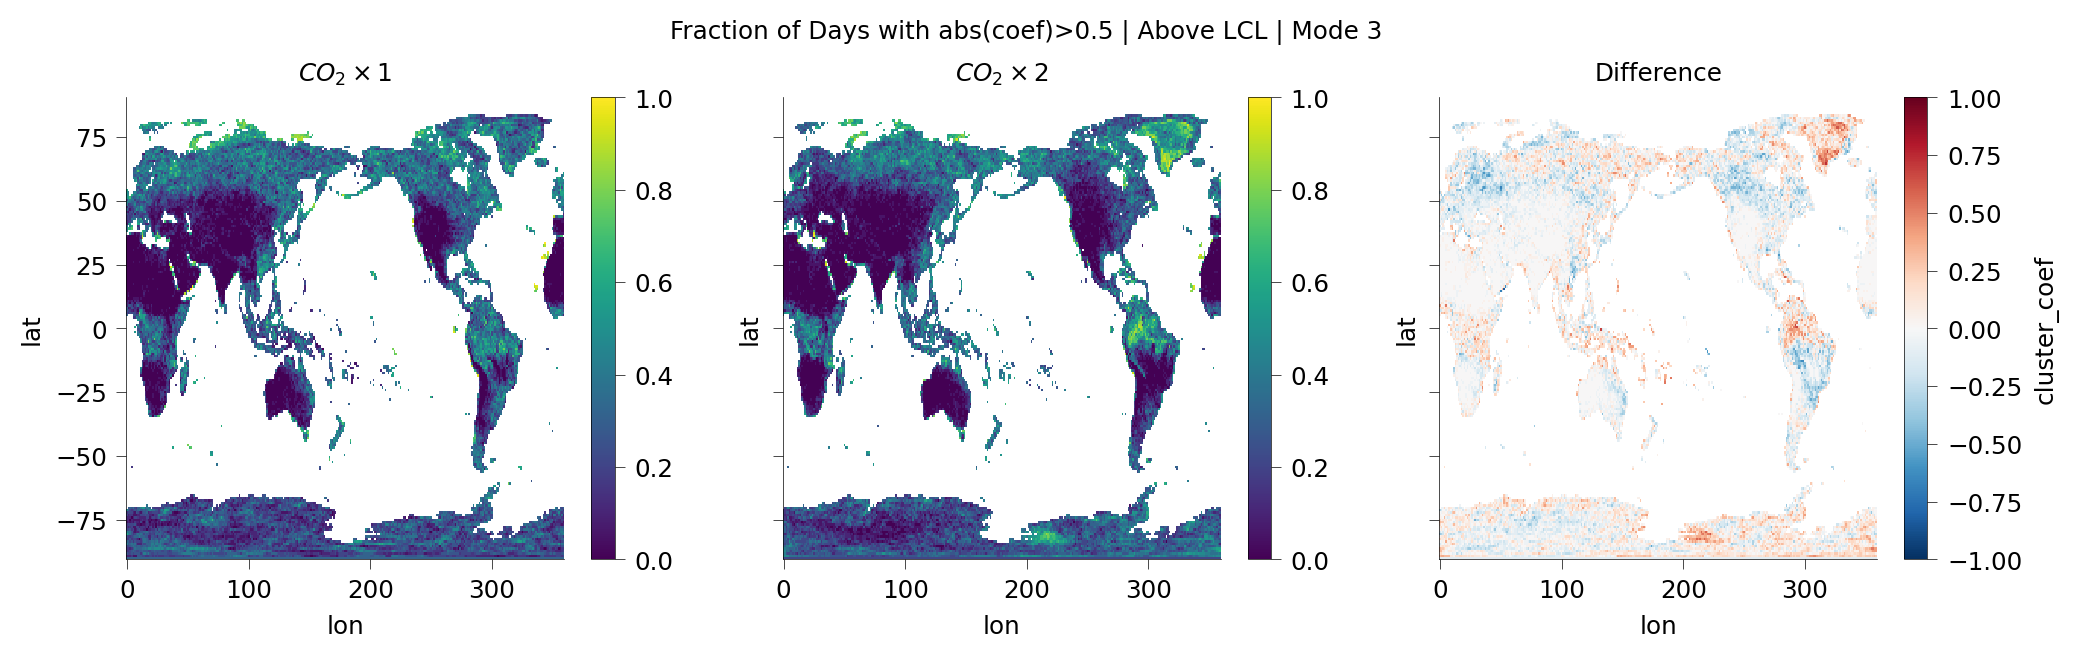

In [44]:
layer_plot = 'above'
mode_plot = 3
frac_coef_thresh = 0.5
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig_resize(fig, 12)
var = []
for i in range(2):
    var.append(((np.abs(ds['cluster_coef'].sel(layer=layer_plot).isel(co2=i, mode=mode_plot)) >
      frac_coef_thresh)/ds.sample.size).sum(dim='sample'))
    im = var[-1].where(lsm).plot(ax=ax[i], vmin=0, vmax=1)
    im.colorbar.set_label("")
    ax[i].set_title(f"$CO_2 \\times {ds.co2.values[i]:.0f}$")
(var[1]-var[0]).where(lsm).plot(ax=ax[2], vmin=-1)
# var[0].min(dim='logp_rel').where(lsm).plot(vmin=-50, ax=ax[1])
# var2 = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use.mse_sat_at_lcl_emp2, ds_use.p_lcl_emp2, ds_use.lnb_ind, logp_custom_grid=logp_grid)
# var2[0].min(dim='logp_rel').where(lsm).plot(vmin=-50, ax=ax[2])
# ax[0].set_title('Physical - Empirical $\sigma_{LCL}$')
ax[2].set_title(f"Difference")
fig.suptitle(f"Fraction of Days with abs(coef)>{frac_coef_thresh} | {layer_plot.capitalize()} LCL | Mode {mode_plot}", y=1.01)
update_fontsize(fig, base_fontsize=10)
plt.show()

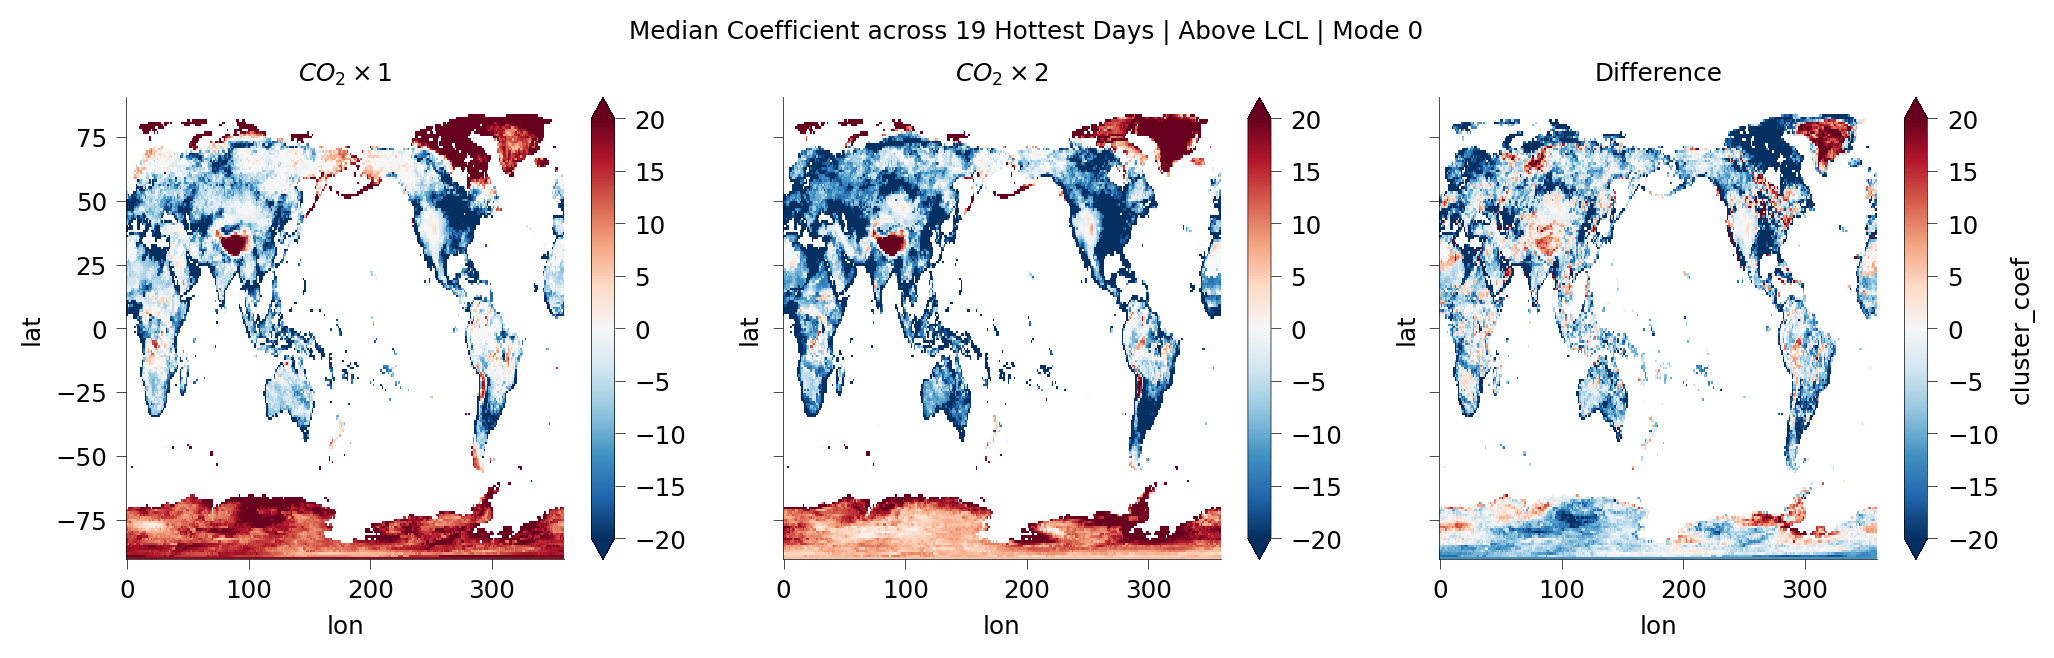

In [45]:
layer_plot = 'above'
mode_plot = 0
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig_resize(fig, 12)
var = []
for i in range(2):
    var.append(ds['cluster_coef'].sel(layer=layer_plot).isel(co2=i, mode=mode_plot).median(dim='sample'))
    im = var[-1].where(lsm).plot(ax=ax[i], vmin=-20 if layer_plot=='above' else -10)
    im.colorbar.set_label("")
    ax[i].set_title(f"$CO_2 \\times {ds.co2.values[i]:.0f}$")
(var[1]-var[0]).where(lsm).plot(ax=ax[2], vmin=-20 if layer_plot=='above' else -10)
# var[0].min(dim='logp_rel').where(lsm).plot(vmin=-50, ax=ax[1])
# var2 = interp_var_to_logp(ds_use.mse_sat, ds_use.P, ds_use.mse_sat_at_lcl_emp2, ds_use.p_lcl_emp2, ds_use.lnb_ind, logp_custom_grid=logp_grid)
# var2[0].min(dim='logp_rel').where(lsm).plot(vmin=-50, ax=ax[2])
# ax[0].set_title('Physical - Empirical $\sigma_{LCL}$')
ax[2].set_title(f"Difference")
fig.suptitle(f"Median Coefficient across {ds.sample.size} Hottest Days | {layer_plot.capitalize()} LCL | Mode {mode_plot}", y=1.01)
update_fontsize(fig, base_fontsize=10)
plt.show()

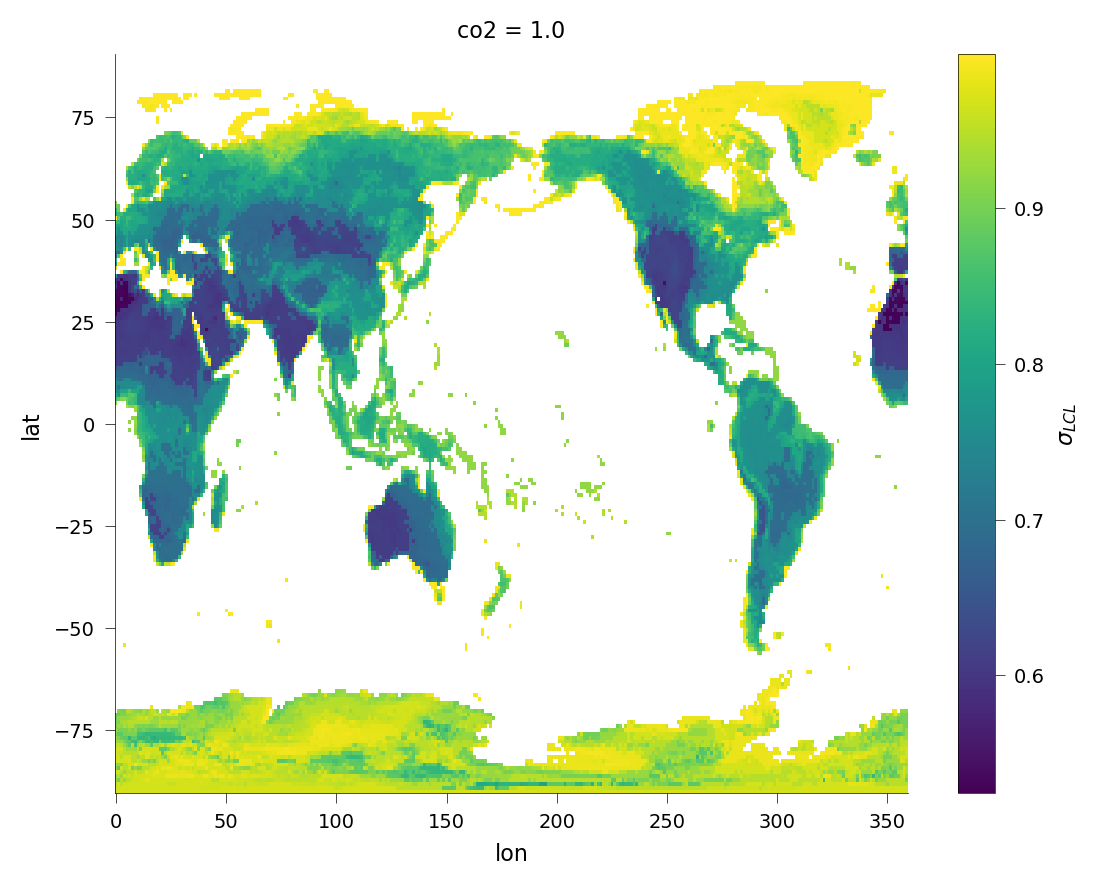

In [46]:
im = (ds.p_lcl/ds.PREFHT).isel(co2=0).median(dim='sample').where(lsm).plot()     # LCL plot useful for comparison
im.colorbar.set_label("$\sigma_{LCL}$")
plt.show()

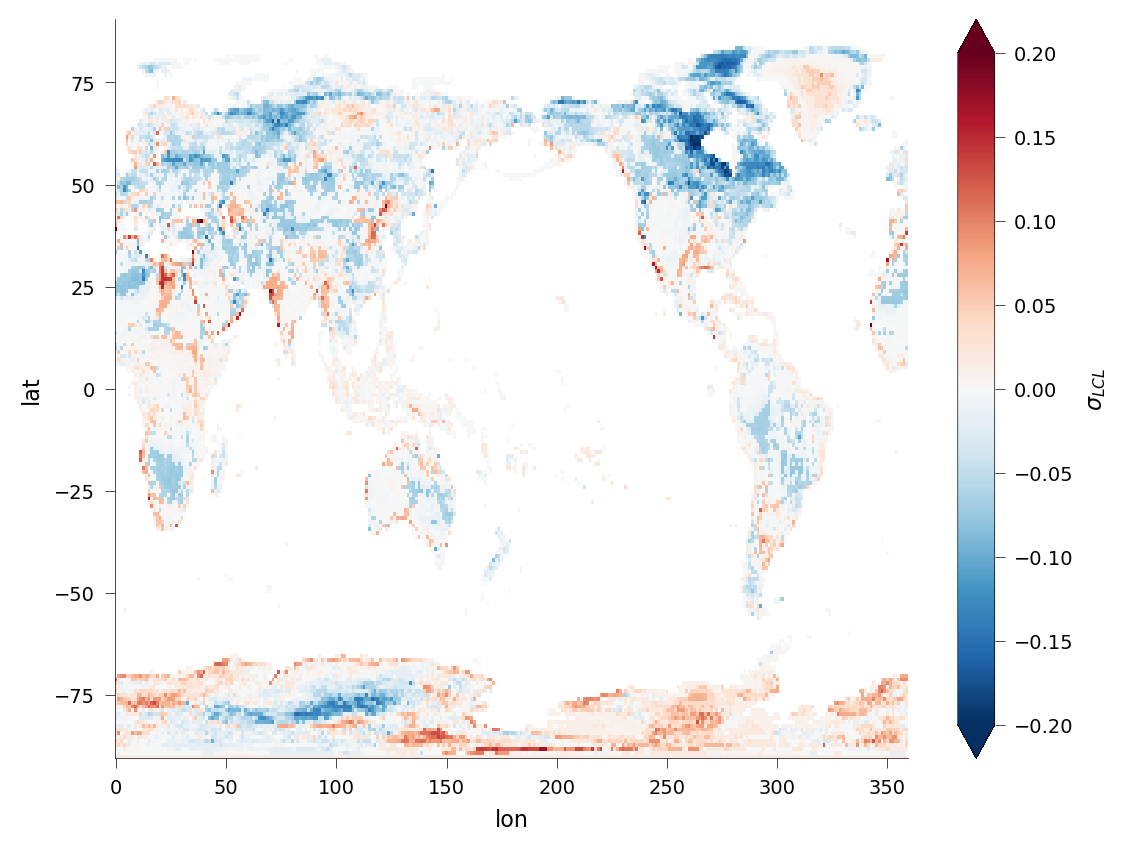

In [47]:
im = ((ds.p_lcl/ds.PREFHT).isel(co2=1).median(dim='sample') -
      (ds.p_lcl/ds.PREFHT).isel(co2=0).median(dim='sample')).where(lsm).plot(vmin=-0.2)     # LCL plot useful for comparison
im.colorbar.set_label("$\sigma_{LCL}$")
plt.show()